## Show me your plate and I tell you who you are

#### Unified Package Loading Prelude

In [82]:
import pickle as pkl 
import pandas as pd 
import numpy as np 
import statsmodels as sml
from scipy import stats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import itertools as it 

In [39]:
### In Case we need it, load using the GeoPandas Kernel
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
### Association Rule Mining Packags
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule


#### Doing an inverse Margaret Thatcher (Not reviving Irish though)

In [ ]:
# Simple adaptable Model Pipeline Factory
def pipeline_factory(scaler, model, x_train, y_train):
    
    pipeline = Pipeline(steps = [
        ('scaler',  scaler),
        ('regressor',   model)
        ], verbose = True)
        
    pipeline.fit(x_train,y_train)
    return pipeline


#### Defining a few interesing Slices for the DF to use

In [69]:
nutrients   = ["energy_fat", "energy_saturate", "energy_sugar", "energy_protein","energy_carb","energy_fibre", "energy_alcohol"]
ethnicities = ["White_perc","Mixed/multiple_ethnic_groups_perc","Asian/Asian_British_perc","Black/African/Caribbean/Black_British_perc","BAME_perc"]
religions = ['Christian_perc','Buddhist_perc','Hindu_perc','Jewish_perc','Muslim_perc','Sikh_perc','No_religion_perc','Other_religion_perc']
products = ["f_beer","f_dairy","f_eggs","f_fats_oils","f_fish","f_fruit_veg","f_grains","f_meat_red","f_poultry","f_readymade","f_sauces","f_soft_drinks","f_spirits","f_sweets","f_tea_coffee","f_water","f_wine"]
education = ["No_qualifications","Edu:Level_1_qualifications","Edu:Level_2_qualifications","Edu:Apprenticeship_","Edu:Level_3_qualifications","Edu:Level_4_qualificationsand_above_","Edu:Other_qualifications"]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [105]:
color_tesco_red = '#EE1C2E'
color_tesco_blue = '#00539F'

### Loading the Data

#### Loading the yearly Tesco Data

In [40]:
### Tesco Data
tesco_path = ("Tesco_Data")

lsoa_year     = pd.read_csv(os.path.join(tesco_path, "year_lsoa_grocery.csv"), index_col = "area_id")
msoa_year     = pd.read_csv(os.path.join(tesco_path, "year_msoa_grocery.csv"), index_col = "area_id")
osward_year   = pd.read_csv(os.path.join(tesco_path, "year_osward_grocery.csv"), index_col = "area_id")

#### Loading the monthly Tesco Data

In [41]:
# Why don't the name of months follow a lexographical ordering

lsoa_months   = pd.DataFrame()
msoa_months   = pd.DataFrame()
osward_months = pd.DataFrame()


for month in months: 
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_lsoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    lsoa_months        = lsoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_msoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    msoa_months        = msoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_osward_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    osward_months      = osward_months.append(loading)
    
lsoa_months["month"]   = pd.Categorical(lsoa_months['month'], categories=months, ordered=True)
msoa_months["month"]   = pd.Categorical(msoa_months['month'], categories=months, ordered=True)
osward_months["month"] = pd.Categorical(osward_months['month'], categories=months, ordered=True)

#### Loading the Socio-Economic Data

In [42]:
### Socio-Economic Data

socio_path = ("Socio_Economic_Data")

lsoa_social     = pd.read_csv(os.path.join(socio_path, "lsoa-data.csv"), encoding = "latin-1", index_col = "Lower Super Output Area")
msoa_social     = pd.read_csv(os.path.join(socio_path, "msoa-data.csv"), encoding = "latin-1", index_col = "Middle Super Output Area")
osward_social   = pd.read_csv(os.path.join(socio_path, "ward-atlas-data.csv"), encoding = "latin-1", header = 1, warn_bad_lines = False, error_bad_lines = False)

# Drops higher Level Aggregation and NaN Rows

lsoa_social     = lsoa_social[lsoa_social["Names"].notna()]
msoa_social     = msoa_social[msoa_social["MSOA Name"].notna()]
osward_social   = osward_social[osward_social["Borough"].notna()]



C:\Users\49171\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (174,175,176,178,189,253,254) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [43]:
## Two LSOA are not accounted for in the Tesco dataset and will be dropped by the join
[x for x in lsoa_social.index if x not in lsoa_year.index]

['E01000328', 'E01003902']

#### Joining the Dataframes

In [44]:
lsoa_combined_year = lsoa_social.join(lsoa_year, how = "inner")
msoa_combined_year = msoa_social.join(msoa_year, how = "inner")

# Consider only Areas with atleast 5% Representative-ness:

lsoa_combined_year     = lsoa_combined_year[lsoa_combined_year.representativeness_norm > 0.05]
msoa_combined_year     = msoa_combined_year[msoa_combined_year.representativeness_norm > 0.05]

# Remove some of the redundant information in the column names and fill in blanks
lsoa_combined_year.columns = ["_".join(x.split(";")[1:]).replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound").replace("_2011", "") if len(x.split(";")) > 1 else x.replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") for x in lsoa_combined_year.columns]
msoa_combined_year.columns = ["_".join(x.split(";")[1:]).replace(" ", "_").replace("(%)_", "perc").replace("(£)", "pound").replace("Highest_level_of_qualification:_", "Edu:").replace("qualifications_", "qualifications") if len(x.split(";")) > 1 else x.replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") for x in msoa_combined_year.columns]

#### Preparing the Brine

In [45]:
print("Turning the Data into a pickle ... ")

jar = "pickle_jar" 

msoa_combined_year.to_pickle(path = os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year.to_pickle(path = os.path.join(jar,"lsoa_combined_year.pkl"))

print("Funniest shit I have ever seen!")

Turning the Data into a pickle ... 
Funniest shit I have ever seen!


#### Taking them out of the Jar again

In [46]:
print("Loading pickled Data")

msoa_combined_year = pd.read_pickle(os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year = pd.read_pickle(os.path.join(jar,"lsoa_combined_year.pkl"))

Loading pickled Data


### Its about Thyme

For a short look into the data we will look into the caloric consumption based on different nutrients on the ward level during the twelve month measuring period

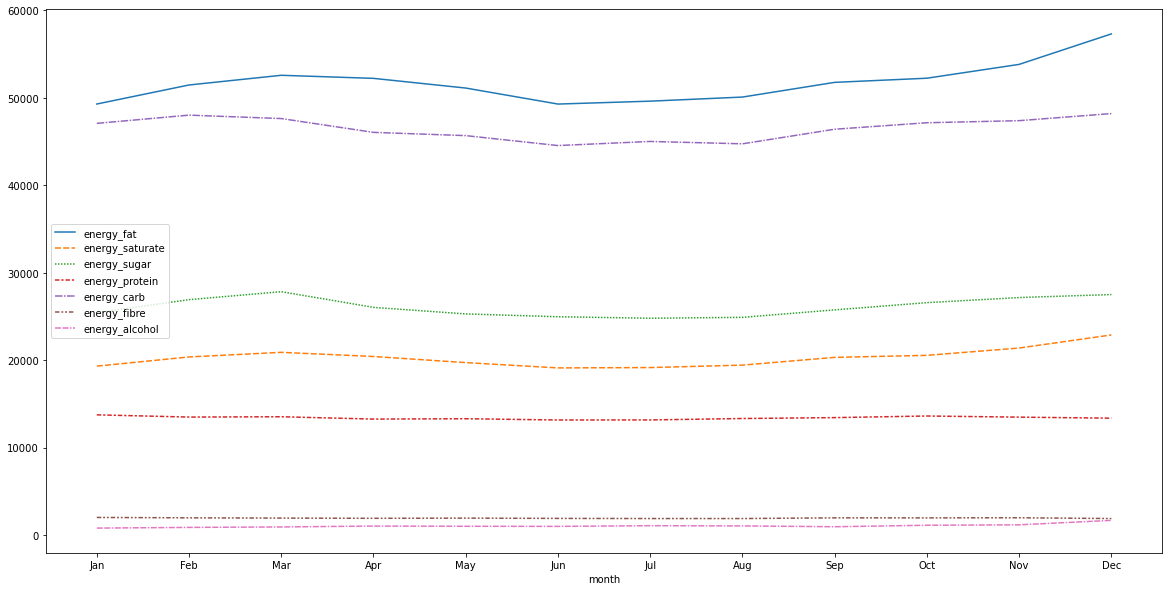

In [47]:
fig, ax = plt.subplots(figsize = (20,10))

g = sns.lineplot(data = osward_months.groupby(by = "month").sum()[nutrients], ax = ax)
plt.show()

#### Some Regression

In [48]:
log_model_interaction_variable = smf.ols(formula='BAME_perc ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              BAME_perc   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     585.8
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:28:43   Log-Likelihood:                -19262.
No. Observations:                4681   AIC:                         3.854e+04
Df Residuals:                    4673   BIC:                         3.859e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         277.0524      5.932     

In [49]:
log_model_interaction_variable = smf.ols(formula='Median_Annual_Household_Income_estimate_pound ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                          OLS Regression Results                                         
Dep. Variable:     Median_Annual_Household_Income_estimate_pound   R-squared:                       0.473
Model:                                                       OLS   Adj. R-squared:                  0.472
Method:                                            Least Squares   F-statistic:                     599.8
Date:                                           Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                                                   18:28:43   Log-Likelihood:                -48838.
No. Observations:                                           4681   AIC:                         9.769e+04
Df Residuals:                                               4673   BIC:                         9.774e+04
Df Model:                                                      7                                         
Covariance Type:                              

#### Barplots for different interesting attributes

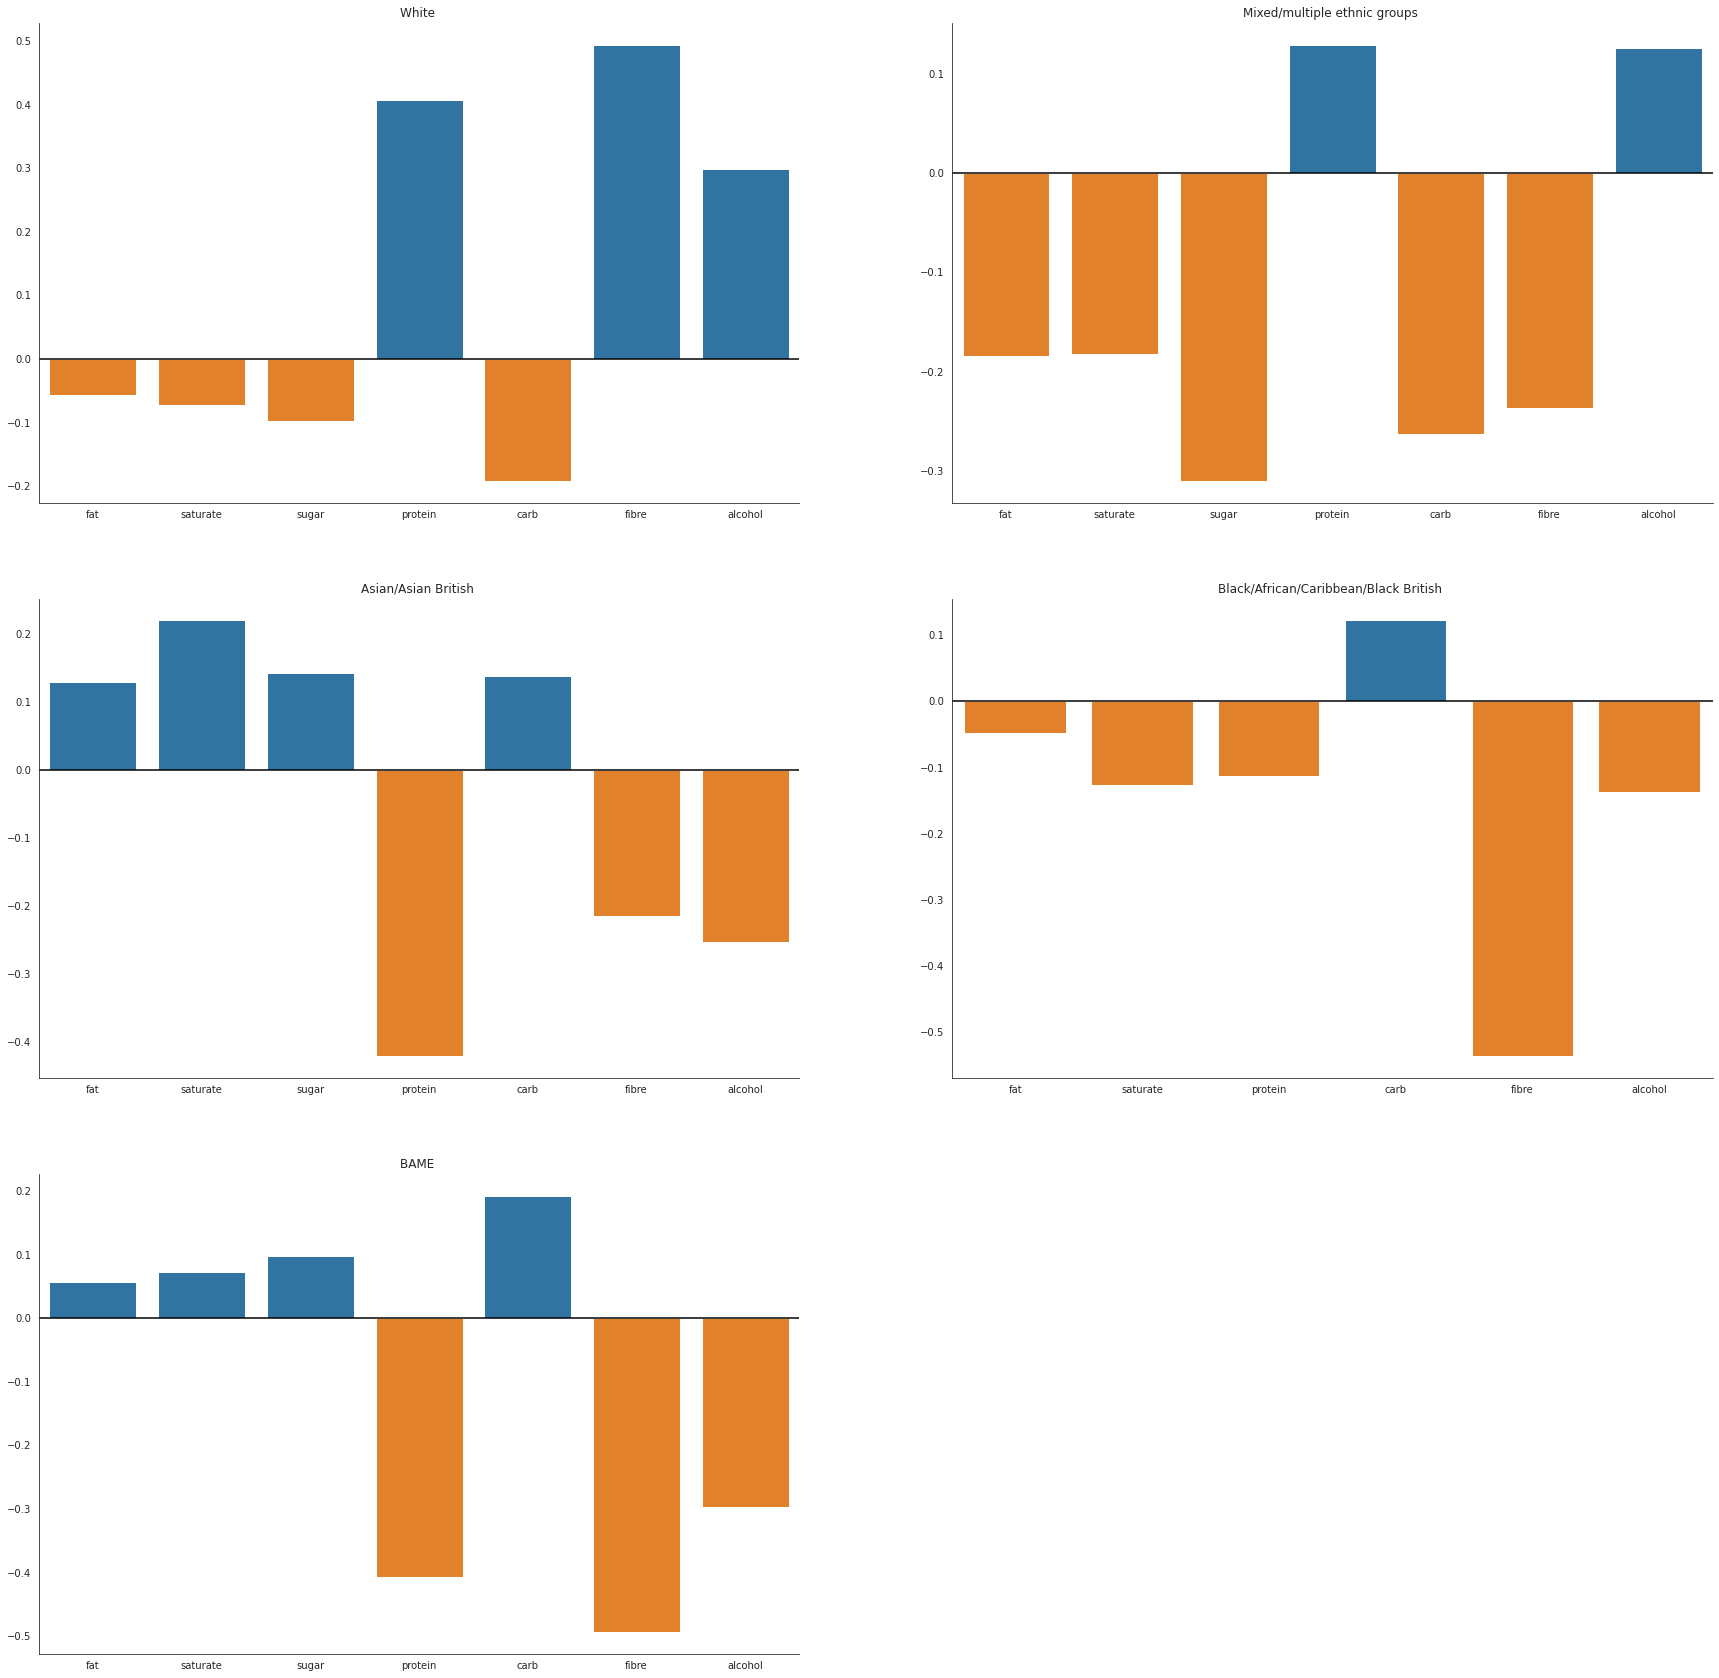

In [50]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,ethnicities):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

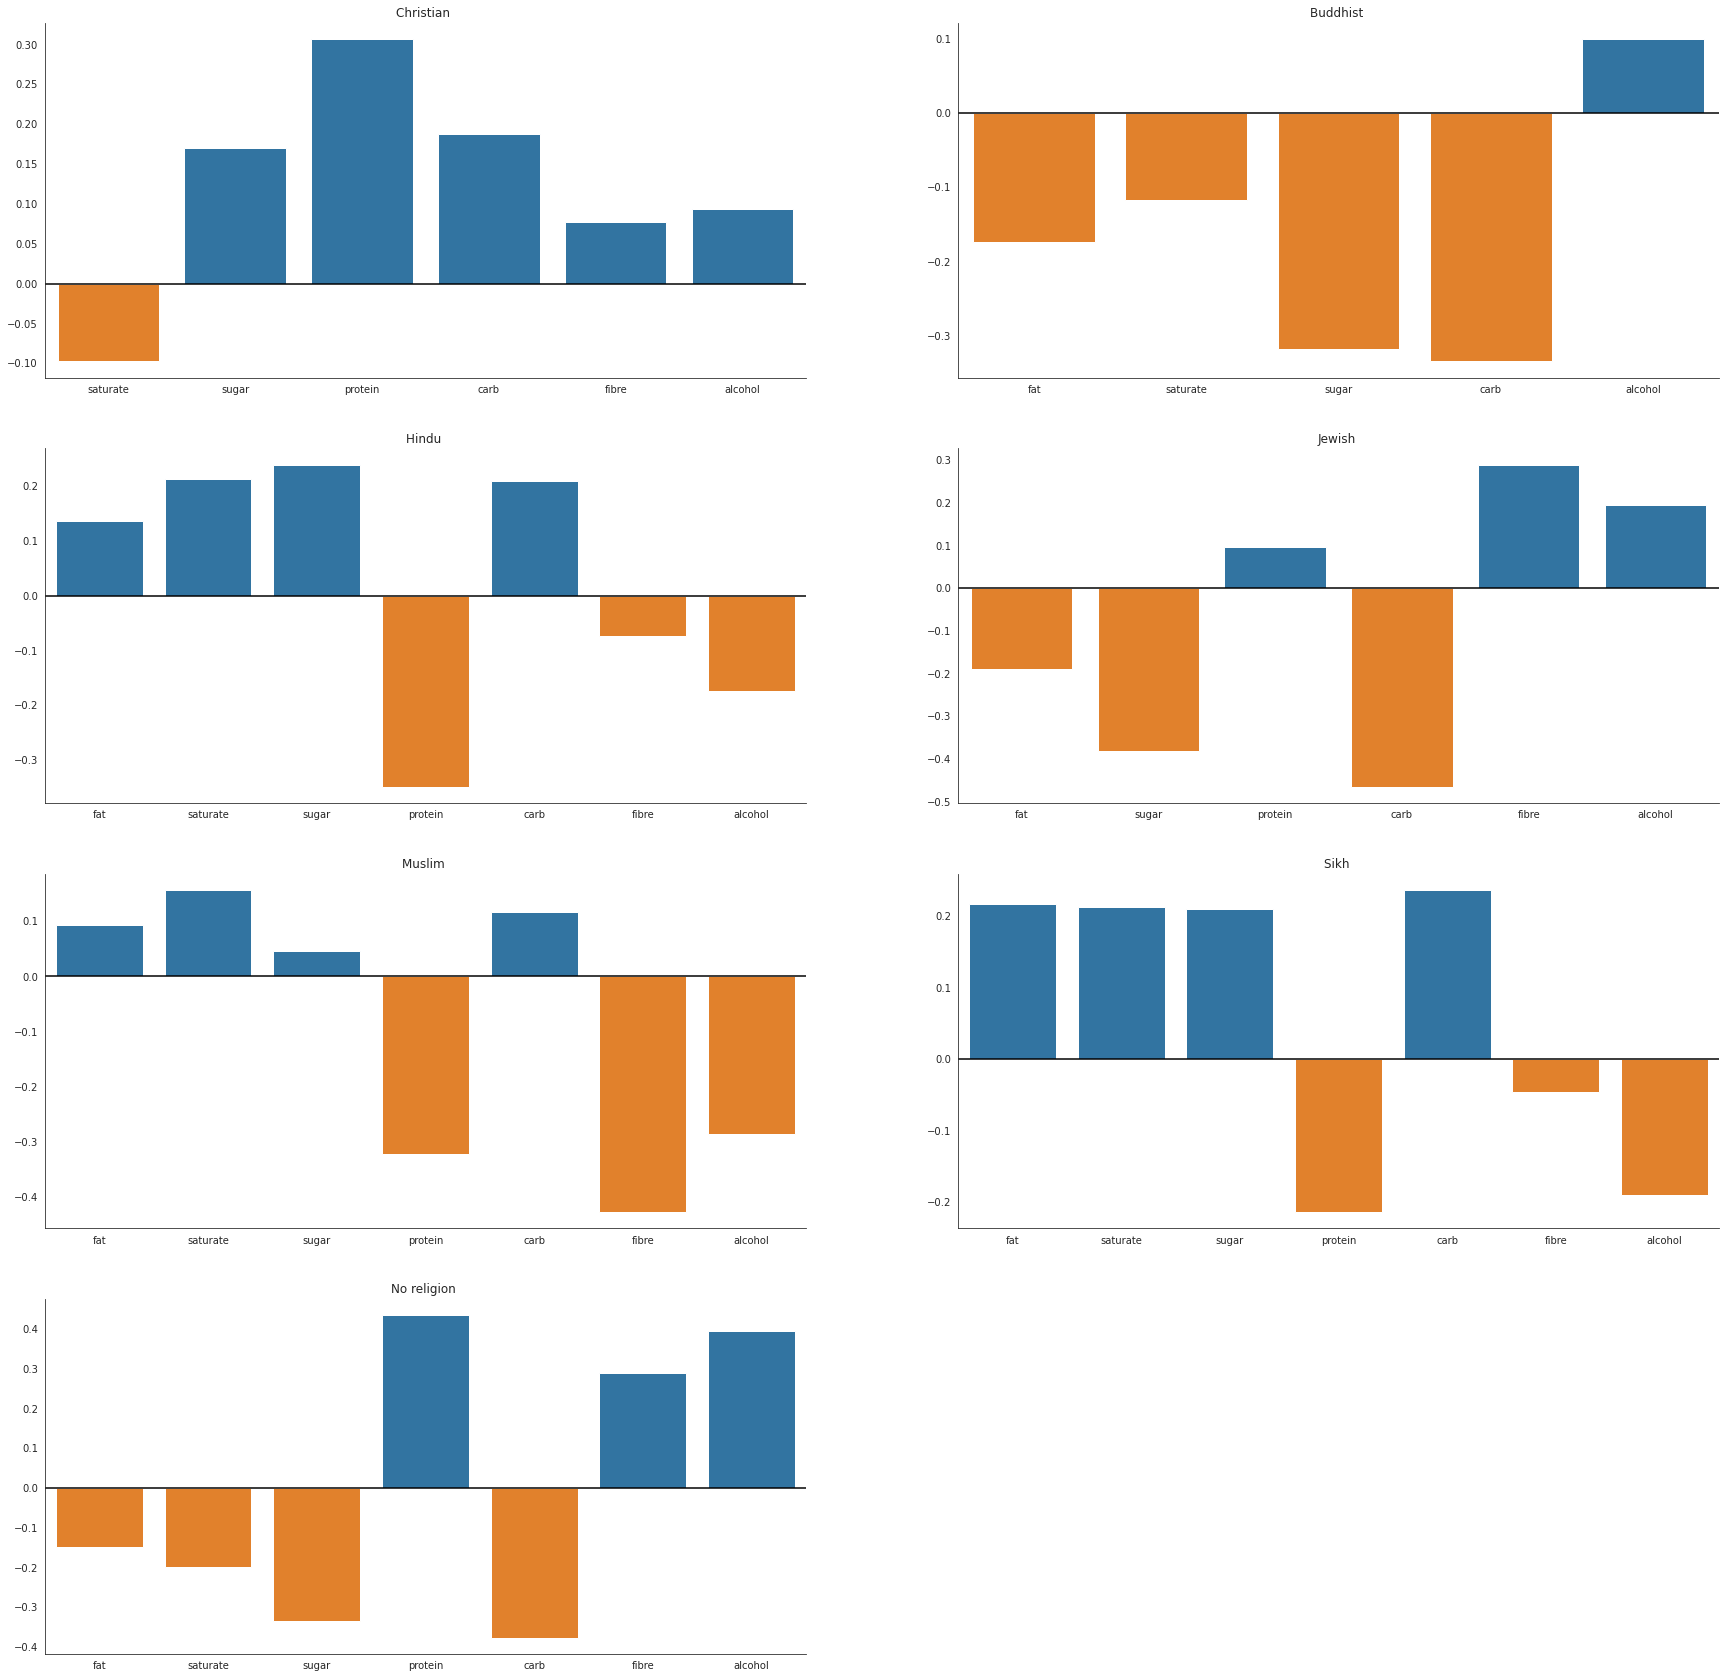

In [51]:
with sns.axes_style("white"): 
    
    f, axes = plt.subplots(4, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, faith in zip(axes,religions):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(faith.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

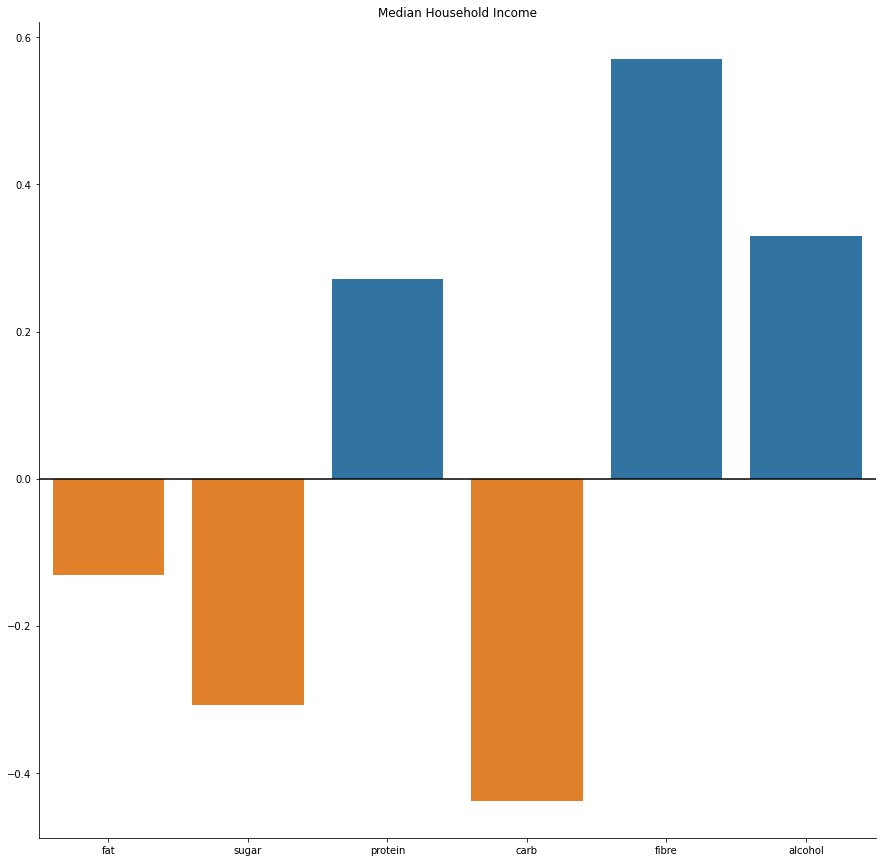

In [52]:
f, (ax) = plt.subplots(1, 1, figsize=(15, 15))
correl = [(nutr, stats.spearmanr(a = lsoa_combined_year["Median_Annual_Household_Income_estimate_pound"], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).pvalue < 0.05]
colors = [0 if c[1] >= 0 else 1 for c in correl]
sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
sns.despine(top = True, right = True)
ax.get_legend().remove()
ax.axhline(0, ls='-', c = 'k')
ax.set_title("Median Household Income")
plt.show()

In [53]:
lsoa_combined_items = lsoa_combined_year[ethnicities + religions + nutrients + ["Median_Annual_Household_Income_estimate_pound"]].copy()
lsoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in  nutrients] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset
for col in lsoa_combined_items.columns:
    lower  =  lsoa_combined_items[col].quantile(0.25)
    middle =  lsoa_combined_items[col].quantile(0.5)
    higher =  lsoa_combined_items[col].quantile(0.75)
    lsoa_combined_items[col + "_Low"] = lsoa_combined_items[col].apply(lambda x : x < lower)
    lsoa_combined_items[col + "_Low_to_Middle"] = lsoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    lsoa_combined_items[col + "_Middle_to_High"] = lsoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    lsoa_combined_items[col + "_High"] = lsoa_combined_items[col].apply(lambda x : x > higher )
    lsoa_combined_items = lsoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(lsoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7007,"(sugar_Low, fibre_High, carb_Low)",(Median_Income_High),0.068148,0.249947,0.054048,0.793103,3.173092,0.037015,3.625258
2221,"(fibre_High, carb_Low)",(Median_Income_High),0.086520,0.249947,0.068361,0.790123,3.161169,0.046736,3.573784
6078,"(fat_High, protein_Low, saturate_High)",(Asian/Asian_High),0.072634,0.249733,0.053835,0.741176,2.967876,0.035696,2.898759
2204,"(sugar_Low, fibre_High)",(Median_Income_High),0.083102,0.249947,0.060671,0.730077,2.920932,0.039900,2.778769
1381,"(protein_Low, saturate_High)",(Asian/Asian_High),0.091006,0.249733,0.066439,0.730047,2.923310,0.043712,2.779250
2225,"(alcohol_Low, fibre_Low)",(Median_Income_Low),0.074343,0.249947,0.053621,0.721264,2.885674,0.035039,2.690913
6954,"(fat_High, protein_Low, saturate_High)",(No_religion_Low),0.072634,0.248451,0.051912,0.714706,2.876645,0.033866,2.634295
1376,"(fat_High, protein_Low)",(Asian/Asian_High),0.081179,0.249733,0.057253,0.705263,2.824069,0.036980,2.545549
2107,"(protein_Low, saturate_High)",(No_religion_Low),0.091006,0.248451,0.064089,0.704225,2.834462,0.041478,2.540951
9877,"(fat_High, protein_Low, saturate_High)","(White_Low, BAME_High)",0.072634,0.249092,0.050630,0.697059,2.798398,0.032538,2.478725


In [54]:
X = lsoa_combined_year[nutrients]
y = lsoa_combined_year['Median_Annual_Household_Income_estimate_pound']
n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

    
for x in tqdm(it.product(n_estimators,max_features)): 
    
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:38, 38.34s/it]

0.4529931862122548

 (75, 'sqrt')


2it [00:44, 28.66s/it]

0.4657369007097455

 (100, 'auto')


3it [01:01, 25.07s/it]

0.4611609464162802

 (100, 'sqrt')


4it [01:08, 19.78s/it]

0.4605969436336023

 (200, 'auto')


5it [01:40, 23.30s/it]

0.46188396130762877

 (200, 'sqrt')


6it [01:52, 19.95s/it]

0.4657977172123003

 (250, 'auto')


7it [02:28, 24.76s/it]

0.46115313383736956

 (250, 'sqrt')


8it [02:44, 20.61s/it]

0.46829761526850583


In [55]:
X = lsoa_combined_year[nutrients]
y = lsoa_combined_year['Median_Annual_Household_Income_estimate_pound']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (20, 0.1)


1it [00:00,  1.36it/s]

0.3486768348295686

 (20, 0.05)


2it [00:01,  1.55it/s]

0.3628648266743604

 (20, 0.01)


3it [00:01,  1.62it/s]

0.36460497658546975

 (50, 0.1)


4it [00:02,  1.44it/s]

0.3032045393109218

 (50, 0.05)


5it [00:03,  1.34it/s]

0.3391835180063608

 (50, 0.01)


6it [00:04,  1.30it/s]

0.3669451058253289

 (100, 0.1)


7it [00:05,  1.00it/s]

0.27537924560299587

 (100, 0.05)


8it [00:07,  1.16s/it]

0.30182863128761217

 (100, 0.01)


9it [00:08,  1.27s/it]

0.3609770746022737

 (200, 0.1)


10it [00:10,  1.49s/it]

0.27018895877823035

 (200, 0.05)


11it [00:13,  1.93s/it]

0.27609568204131063

 (200, 0.01)


12it [00:16,  2.26s/it]

0.34725234309774883

 (250, 0.1)


13it [00:18,  2.18s/it]

0.2689895360474681

 (250, 0.05)


14it [00:22,  2.67s/it]

0.2717842998608302

 (250, 0.01)


15it [00:26,  1.75s/it]

0.3407665580750724


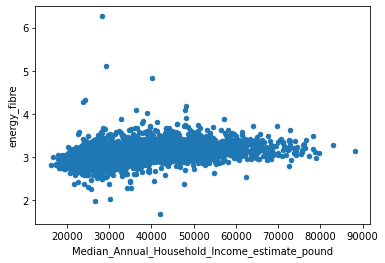

In [56]:
lsoa_combined_year.plot.scatter(x = "Median_Annual_Household_Income_estimate_pound", y = "energy_fibre" )

In [57]:
# Shuffle Split 
x_train, x_test , y_train, y_test = train_test_split(lsoa_combined_year[nutrients], lsoa_combined_year['Median_Annual_Household_Income_estimate_pound'], random_state=0) 
# The Ada Pipeline 
ada_pipeline = pipeline_factory(scaler = StandardScaler(), model = AdaBoostRegressor(base_estimator = LinearRegression()), x_train = x_train, y_train = y_train)

ada_pipeline.score(x_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.1s


0.29422327058446573

In [58]:
# Shuffle Split 
x_train, x_test , y_train, y_test = train_test_split(msoa_combined_year[nutrients], msoa_combined_year['Total_Median_Annual_Household_Income_pound_'], random_state=0) 
# The Ada Pipeline 
ada_pipeline = pipeline_factory(scaler = StandardScaler(), model = AdaBoostRegressor(base_estimator = LinearRegression()), x_train = x_train, y_train = y_train)

ada_pipeline.score(x_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


0.5916198554571601

In [59]:

X = msoa_combined_year[nutrients]
y = msoa_combined_year['Total_Median_Annual_Household_Income_pound_']

n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

for x in tqdm(it.product(n_estimators,max_features)): 
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:02,  2.14s/it]

0.5568301990827698

 (75, 'sqrt')


2it [00:03,  1.92s/it]

0.5714009928283768

 (100, 'auto')


3it [00:06,  2.21s/it]

0.559054316140492

 (100, 'sqrt')


4it [00:08,  2.07s/it]

0.5638348759583334

 (200, 'auto')


5it [00:13,  3.18s/it]

0.560111011265736

 (200, 'sqrt')


6it [00:17,  3.26s/it]

0.5688248539522524

 (250, 'auto')


7it [00:24,  4.37s/it]

0.5631094777884649

 (250, 'sqrt')


8it [00:28,  3.60s/it]

0.5665135750284136


In [60]:
X = msoa_combined_year[nutrients]
y = msoa_combined_year['Total_Median_Annual_Household_Income_pound_']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
  
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (20, 0.1)


1it [00:00,  4.39it/s]

0.4919242570449689

 (20, 0.05)


2it [00:00,  4.13it/s]

0.502761209929587

 (20, 0.01)


3it [00:00,  4.13it/s]

0.5001194908631519

 (50, 0.1)


4it [00:01,  3.15it/s]

0.4583233179491858

 (50, 0.05)


5it [00:01,  2.78it/s]

0.4864653692802382

 (50, 0.01)


6it [00:02,  2.60it/s]

0.5009370908515549

 (100, 0.1)


7it [00:02,  2.15it/s]

0.4461290076599127

 (100, 0.05)


8it [00:03,  1.76it/s]

0.4623316326291057

 (100, 0.01)


9it [00:04,  1.55it/s]

0.5002953946928905

 (200, 0.1)


10it [00:05,  1.55it/s]

0.44443801855386084

 (200, 0.05)


11it [00:06,  1.28it/s]

0.446089458994253

 (200, 0.01)


12it [00:07,  1.01s/it]

0.4913740410808793

 (250, 0.1)


13it [00:08,  1.07it/s]

0.4454097249277629

 (250, 0.05)


14it [00:09,  1.02s/it]

0.4500935183967944

 (250, 0.01)


15it [00:11,  1.30it/s]

0.48747917719551986


In [61]:
msoa_combined_items = msoa_combined_year[ethnicities + religions + nutrients + ["Total_Median_Annual_Household_Income_pound_"]].copy()
msoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in  nutrients] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12322,"(alcohol_High, fibre_High, carb_Low)",(Median_Income_High),0.051688,0.250000,0.050633,0.979592,3.918367,0.037711,36.750000
2899,"(alcohol_High, fibre_High)",(Median_Income_High),0.070675,0.250000,0.063291,0.895522,3.582090,0.045622,7.178571
9444,"(protein_Low, alcohol_Low, saturate_High)",(Asian/Asian_High),0.059072,0.250000,0.051688,0.875000,3.500000,0.036920,6.000000
9459,"(alcohol_Low, protein_Low, carb_High)",(Asian/Asian_High),0.063291,0.250000,0.054852,0.866667,3.466667,0.039030,5.625000
6657,"(alcohol_High, fibre_High)","(BAME_Low, White_High)",0.070675,0.250000,0.060127,0.850746,3.402985,0.042458,5.025000
1971,"(alcohol_High, fibre_High)",(BAME_Low),0.070675,0.250000,0.060127,0.850746,3.402985,0.042458,5.025000
978,"(alcohol_High, fibre_High)",(White_High),0.070675,0.250000,0.060127,0.850746,3.402985,0.042458,5.025000
12204,"(protein_Low, alcohol_Low, carb_High)",(No_religion_Low),0.063291,0.250000,0.053797,0.850000,3.400000,0.037975,5.000000
9423,"(fat_High, alcohol_Low, protein_Low)",(Asian/Asian_High),0.062236,0.250000,0.052743,0.847458,3.389831,0.037184,4.916667
9439,"(protein_Low, saturate_High, carb_High)",(Asian/Asian_High),0.072785,0.250000,0.061181,0.840580,3.362319,0.042985,4.704545


In [62]:
log_model_interaction_variable = smf.ols(formula='BAME_perc ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              BAME_perc   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     252.8
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          4.00e-211
Time:                        18:33:22   Log-Likelihood:                -3646.0
No. Observations:                 948   AIC:                             7308.
Df Residuals:                     940   BIC:                             7347.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         389.9415     14.387     

In [63]:
log_model_interaction_variable = smf.ols(formula='Total_Median_Annual_Household_Income_pound_ ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Total_Median_Annual_Household_Income_pound_   R-squared:                       0.595
Model:                                                     OLS   Adj. R-squared:                  0.592
Method:                                          Least Squares   F-statistic:                     197.6
Date:                                         Wed, 25 Nov 2020   Prob (F-statistic):          8.59e-180
Time:                                                 18:33:22   Log-Likelihood:                -9737.3
No. Observations:                                          948   AIC:                         1.949e+04
Df Residuals:                                              940   BIC:                         1.953e+04
Df Model:                                                    7                                         
Covariance Type:                                     nonrobust  

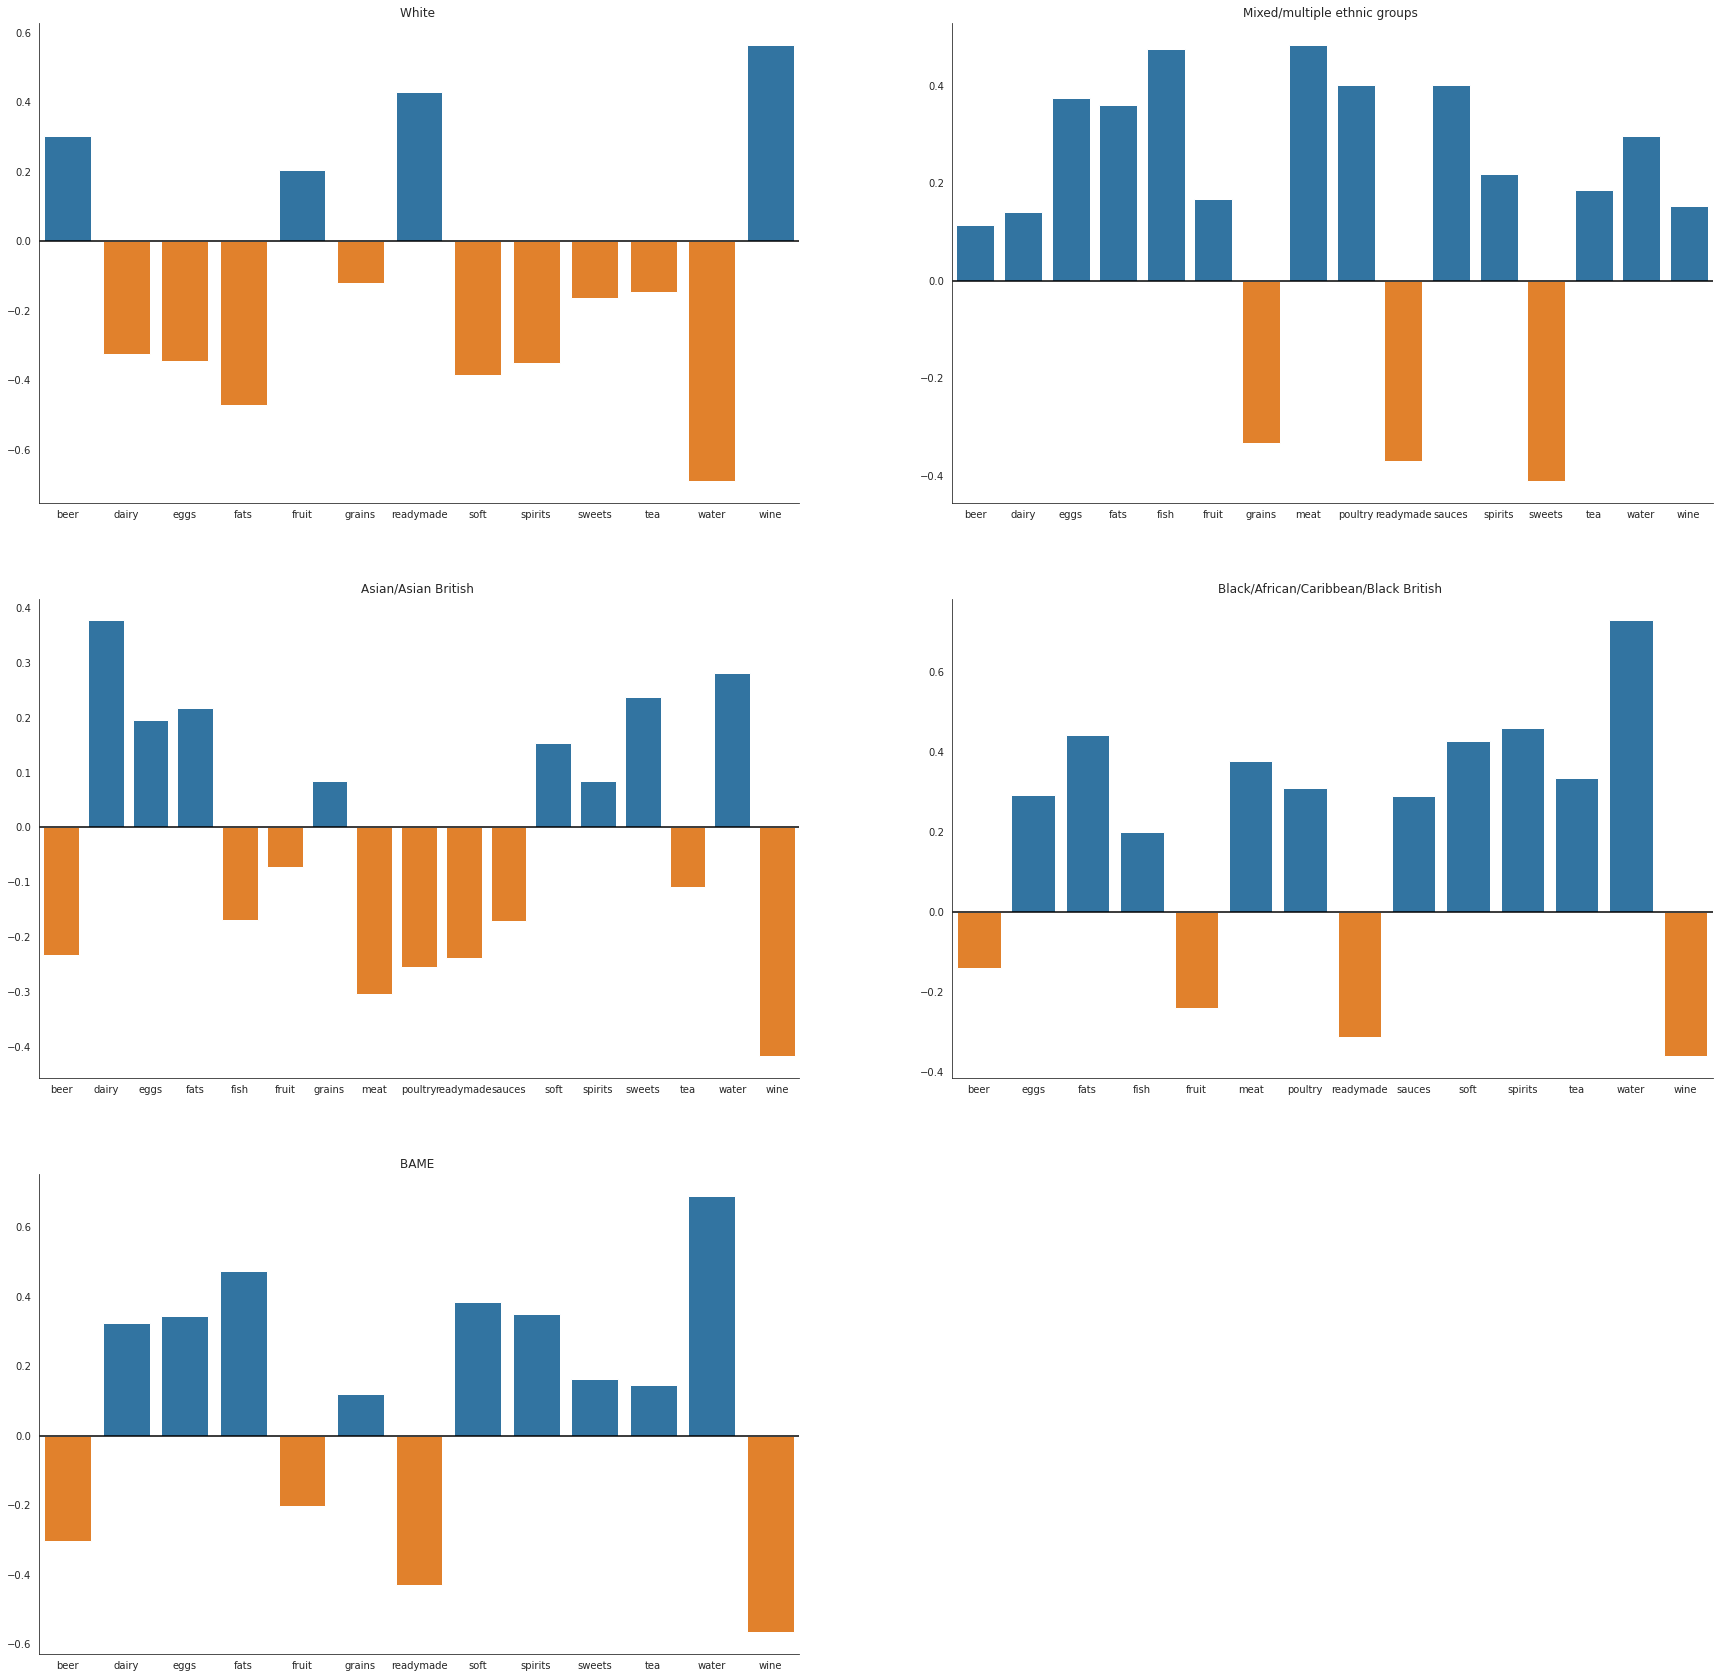

In [65]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,ethnicities):
        correl = [(nutr, stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).correlation) for nutr in products if stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()



In [67]:
msoa_combined_items = msoa_combined_year[ethnicities + religions + products + ["Total_Median_Annual_Household_Income_pound_"]].copy()
msoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in products] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in products]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4421,"(readymade_Low, meat_Low)",(Christian_Low),0.059072,0.248945,0.056962,0.964286,3.873487,0.042256,21.029536
26841,"(dairy_High, meat_Low, poultry_Low)",(Christian_Low),0.052743,0.248945,0.050633,0.960000,3.856271,0.037503,18.776371
23036,"(water_Low, fats_Low, readymade_High)",(Black/African/Caribbean/Black_Low),0.060127,0.247890,0.056962,0.947368,3.821725,0.042057,14.290084
34239,"(tea_Low, wine_High, soft_Low)",(Median_Income_High),0.059072,0.250000,0.055907,0.946429,3.785714,0.041139,14.000000
221536,"(fruit_High, soft_Low, water_Low, fish_High, w...",(Median_Income_High),0.054852,0.250000,0.051688,0.942308,3.769231,0.037975,13.000000
221730,"(sweets_Low, soft_Low, water_Low, fish_High, w...",(Median_Income_High),0.053797,0.250000,0.050633,0.941176,3.764706,0.037184,12.750000
222113,"(sweets_Low, soft_Low, water_Low, grains_Low, ...",(Median_Income_High),0.064346,0.250000,0.060127,0.934426,3.737705,0.044040,11.437500
372054,"(fruit_High, sweets_Low, soft_Low, water_Low, ...",(Median_Income_High),0.063291,0.250000,0.059072,0.933333,3.733333,0.043249,11.250000
100392,"(water_Low, fish_High, wine_High, fruit_High)",(Median_Income_High),0.060127,0.250000,0.055907,0.929825,3.719298,0.040876,10.687500
3518,"(water_High, meat_High)",(Black/African/Caribbean/Black_High),0.059072,0.250000,0.054852,0.928571,3.714286,0.040084,10.500000


In [70]:
# The Education values are only addressing Adults (> 15 years) 
msoa_combined_year[education + ["All_Ages_", "0-15_"]]

,No_qualifications,Edu:Level_1_qualifications,Edu:Level_2_qualifications,Edu:Apprenticeship_,Edu:Level_3_qualifications,Edu:Level_4_qualificationsand_above_,Edu:Other_qualifications,All_Ages_,0-15_
E02000001,454,291,445,47,484,4618,416,7375,620
E02000002,1623,789,706,118,479,914,395,6775,1751
E02000003,1778,1210,1236,169,847,1829,729,10045,2247
E02000004,1502,800,825,163,539,891,266,6182,1196
E02000005,1839,1026,1038,160,653,1119,527,8562,2200
...,...,...,...,...,...,...,...,...,...
E02000979,765,439,596,68,656,3726,803,8081,1028
E02000980,1035,581,614,80,601,3716,780,8684,1277
E02000981,611,399,529,66,696,5028,749,8991,913
E02000982,1069,574,671,83,624,2960,799,8226,1446


In [71]:
msoa_combined_year[education].sum(axis = 1)

E02000001    6755
E02000002    5024
E02000003    7798
E02000004    4986
E02000005    6362
             ... 
E02000979    7053
E02000980    7407
E02000981    8078
E02000982    6780
E02000983    7177
Length: 948, dtype: int64

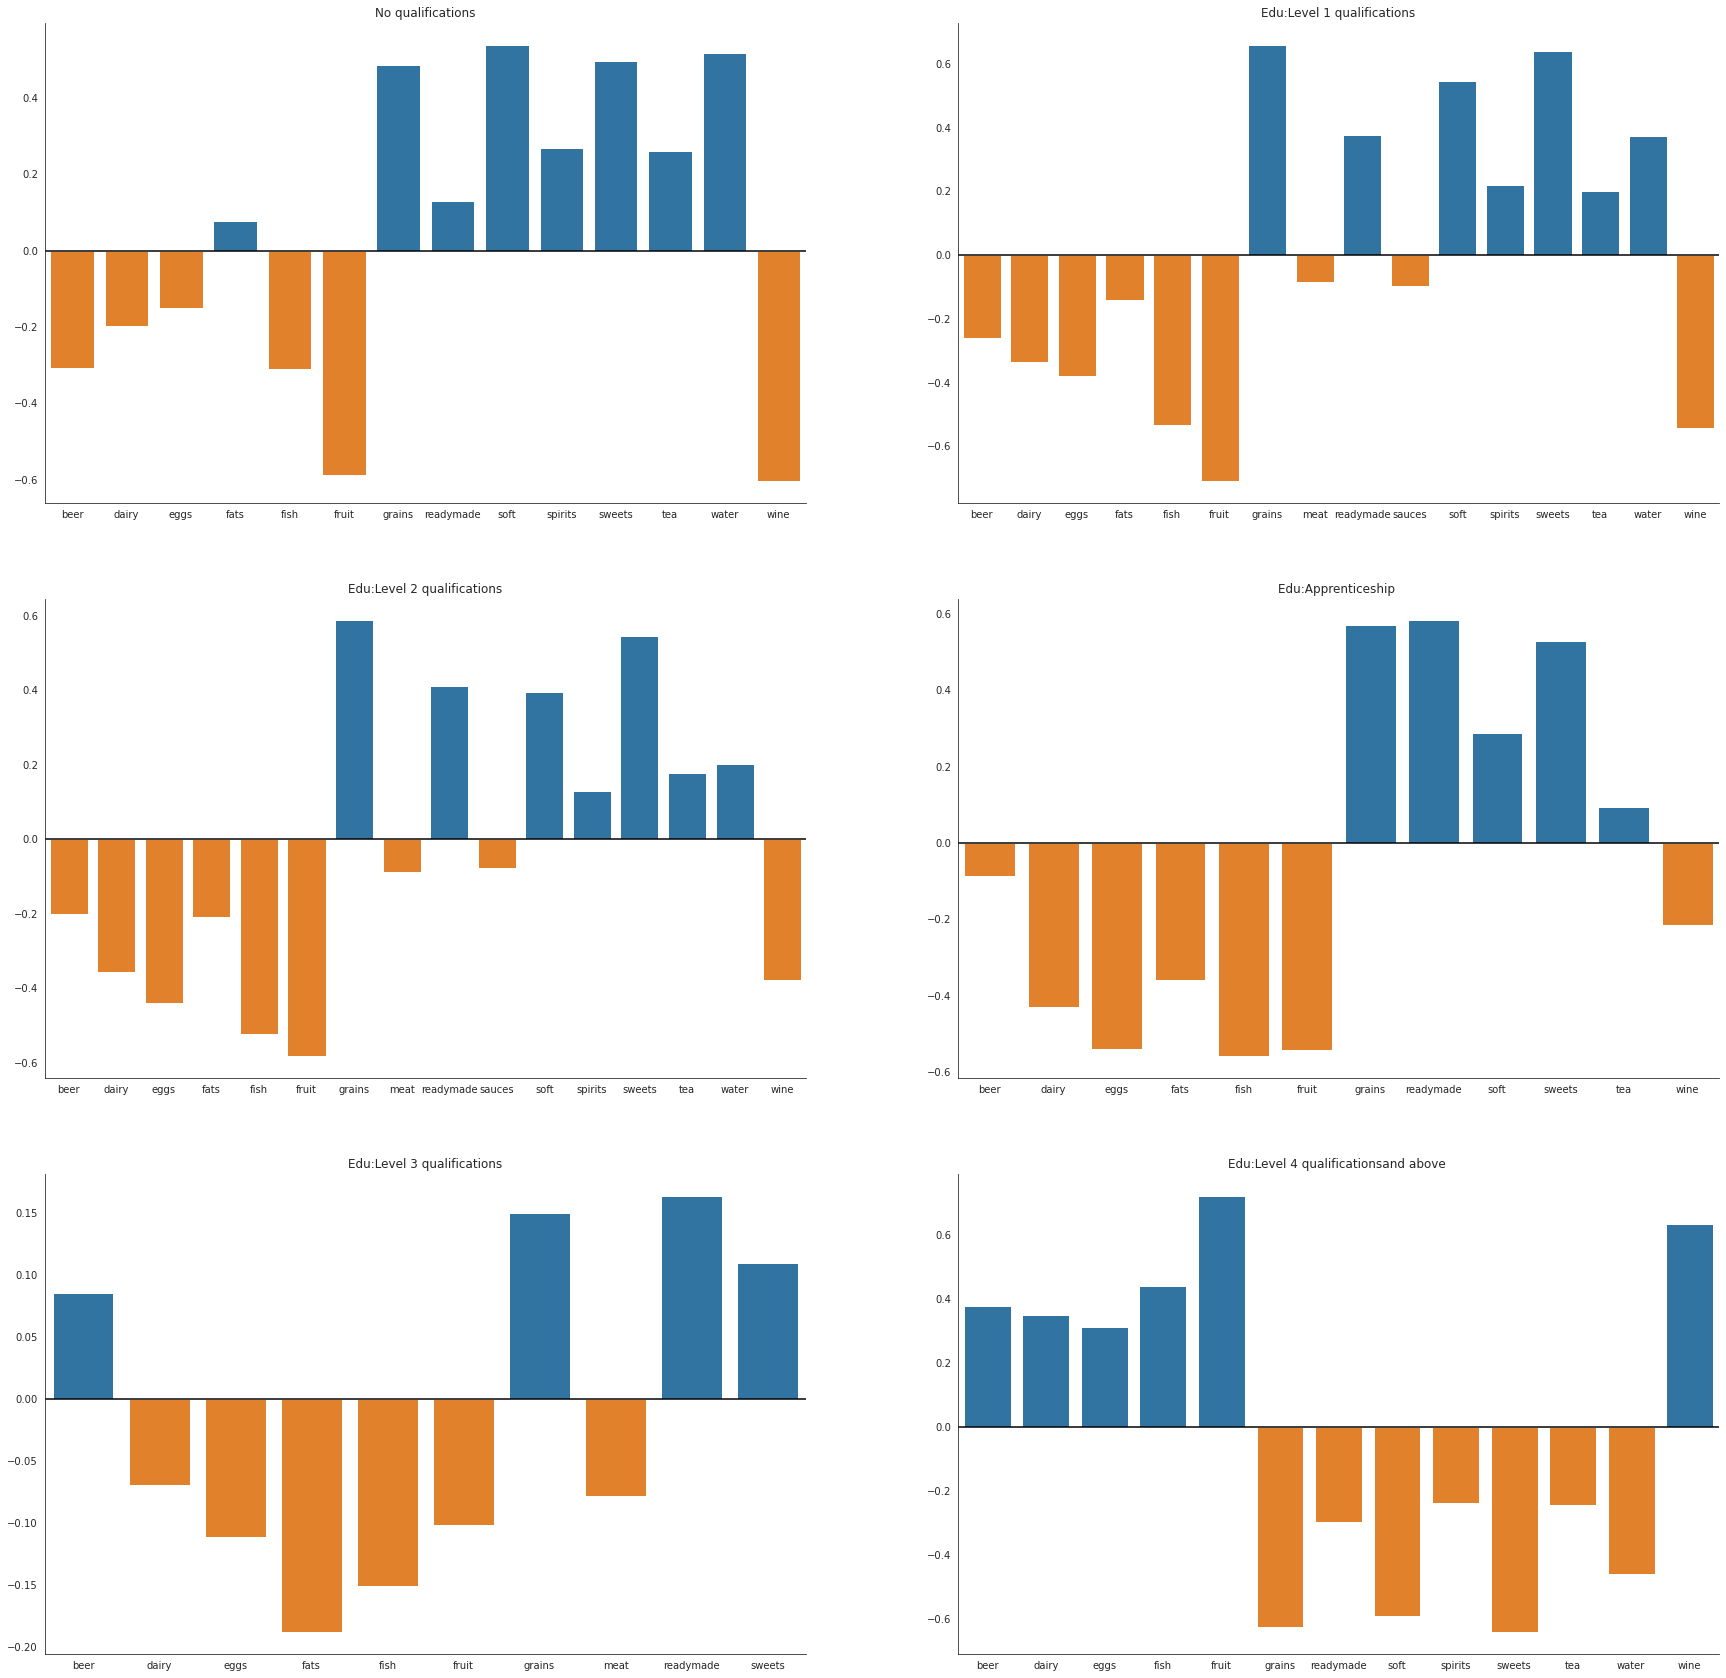

In [72]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,education):
        correl = [(nutr, stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).correlation) for nutr in products if stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)

plt.show()

In [73]:
msoa_combined_items = msoa_combined_year[ethnicities + products + education + ["Total_Median_Annual_Household_Income_pound_"]].copy()
msoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + [x.split("_")[1] for x in products] + [x.replace("Edu:","").replace("and_above_","").replace("_qualifications","").replace("Apprenticeship_", "Apprenticeship") for x in education]  + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

print("Computing Frequent Itemset ...")
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.1, use_colnames = True)



# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in products]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)
print("Computing Association Rules ...")
rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
print("Cleaning Rule Set for desiered Rules ...")
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

Computing Frequent Itemset ...
Computing Association Rules ...
Cleaning Rule Set for desiered Rules ...


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1173,"(water_Low, sweets_Low)",(Level_1_Low),0.111814,0.250000,0.102321,0.915094,3.660377,0.074367,8.833333
2138,"(water_Low, grains_Low, fruit_High)",(Level_1_Low),0.113924,0.250000,0.101266,0.888889,3.555556,0.072785,6.750000
2675,"(water_Low, wine_High, soft_Low)",(Median_Income_High),0.114979,0.250000,0.101266,0.880734,3.522936,0.072521,6.288462
2128,"(water_Low, grains_Low, fruit_High)",(No_Low),0.113924,0.248945,0.100211,0.879630,3.533427,0.071850,6.239533
3032,"(eggs_Low, fats_Low, readymade_High, grains_High)",(Apprenticeship_High),0.118143,0.248945,0.102321,0.866071,3.478965,0.072909,5.607876
907,"(fruit_High, wine_High)",(Level_1_Low),0.130802,0.250000,0.112869,0.862903,3.451613,0.080169,5.470588
2550,"(grains_Low, soft_Low, sweets_Low)",(Level_1_Low),0.123418,0.250000,0.105485,0.854701,3.418803,0.074631,5.161765
3056,"(grains_Low, soft_Low, fruit_High, sweets_Low)",(Level_1_Low),0.122363,0.250000,0.104430,0.853448,3.413793,0.073840,5.117647
1882,"(sweets_High, eggs_Low, readymade_High)",(Apprenticeship_High),0.122363,0.248945,0.104430,0.853448,3.428258,0.073969,5.124845
2242,"(water_Low, fruit_High, soft_Low)",(No_Low),0.126582,0.248945,0.107595,0.850000,3.414407,0.076083,5.007032


In [74]:
msoa_combined_items = msoa_combined_year[ethnicities + nutrients + education + ["Total_Median_Annual_Household_Income_pound_"]].copy()
msoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + [x.split("_")[1] for x in nutrients] + [x.replace("Edu:","").replace("and_above_","").replace("_qualifications","").replace("Apprenticeship_", "Apprenticeship") for x in education]  + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

print("Computing Frequent Itemset ...")
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.1, use_colnames = True)



# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)
print("Computing Association Rules ...")
rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
print("Cleaning Rule Set for desiered Rules ...")
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

Computing Frequent Itemset ...
Computing Association Rules ...
Cleaning Rule Set for desiered Rules ...


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
306,"(alcohol_High, carb_Low)",(Level_1_Low),0.130802,0.250000,0.102321,0.782258,3.129032,0.069620,3.444444
308,"(alcohol_High, carb_Low)",(Level_4_High),0.130802,0.250000,0.100211,0.766129,3.064516,0.067511,3.206897
259,"(sugar_Low, carb_Low)",(Level_1_Low),0.184599,0.250000,0.141350,0.765714,3.062857,0.095200,3.201220
47,(carb_Low),(Level_1_Low),0.250000,0.250000,0.177215,0.708861,2.835443,0.114715,2.576087
267,"(sugar_Low, carb_Low)",(Level_4_High),0.184599,0.250000,0.128692,0.697143,2.788571,0.082542,2.476415
263,"(sugar_Low, carb_Low)",(Level_2_Low),0.184599,0.250000,0.126582,0.685714,2.742857,0.080432,2.386364
255,"(sugar_Low, carb_Low)",(No_Low),0.184599,0.248945,0.126582,0.685714,2.754479,0.080627,2.389720
565,"(sugar_Low, carb_Low)","(Level_1_Low, No_Low)",0.184599,0.200422,0.123418,0.668571,3.335820,0.086420,2.412520
51,(carb_Low),(Level_4_High),0.250000,0.250000,0.165612,0.662447,2.649789,0.103112,2.221875
587,"(sugar_Low, carb_Low)","(Level_2_Low, Level_1_Low)",0.184599,0.200422,0.120253,0.651429,3.250286,0.083255,2.293871


https://pypi.org/project/pyarmviz/

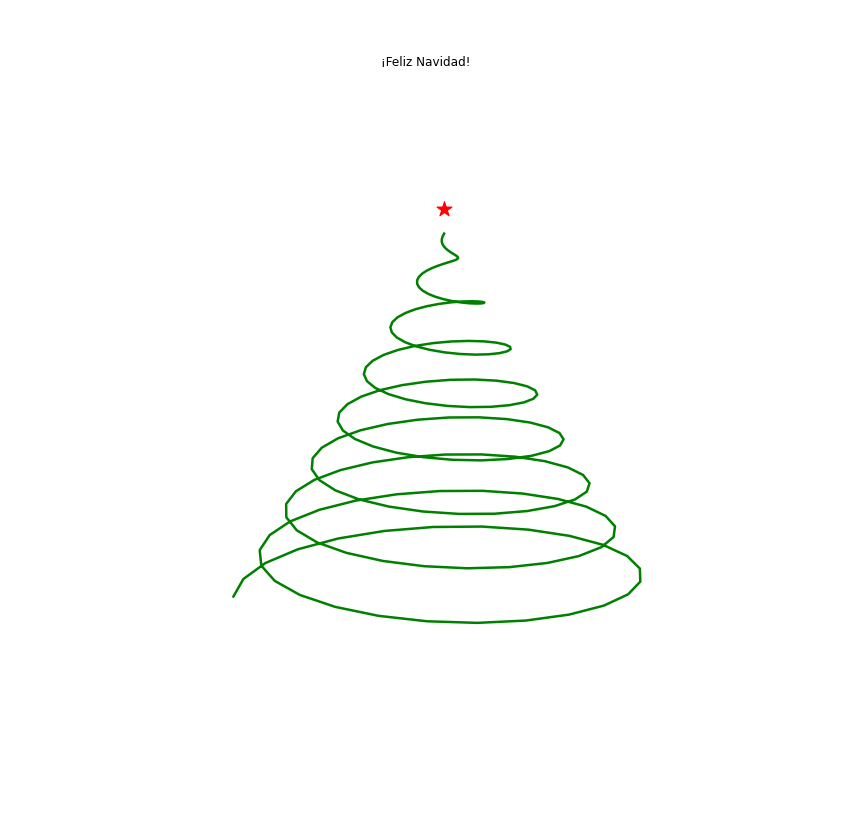

In [75]:
# Calculate spiral coordinates for the Xmas tree
theta = np.linspace(-8 * np.pi, 8 * np.pi, 200) 
z = np.linspace(-3, 0, 200)
r = 5
x = r * np.sin(theta)*z
y = r * np.cos(theta)*z
 
# Use matplotib and its OOP interface to draw it 
fig = plt.figure(figsize  = (15,15)) # Create figure
fig.set
ax = fig.gca(projection='3d') # It's a 3D Xmas tree!
ax.view_init(15, 0) # Set a nice view angle
ax._axis3don = False # Hide the 3d axes
 
# Plot the Xmas tree as a line
ax.plot(x, y, z,
        c='green', linewidth=2.5)
 
# Every Xmas tree needs a star
ax.scatter(0, 0, 0.2,
           c='red', s=250, marker='*')
 
# Type here your best whishes
ax.set_title(u"¡Feliz Navidad!")
 
plt.show()

[1, 1, 1, 1, 0, 0]
[1, 0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0]


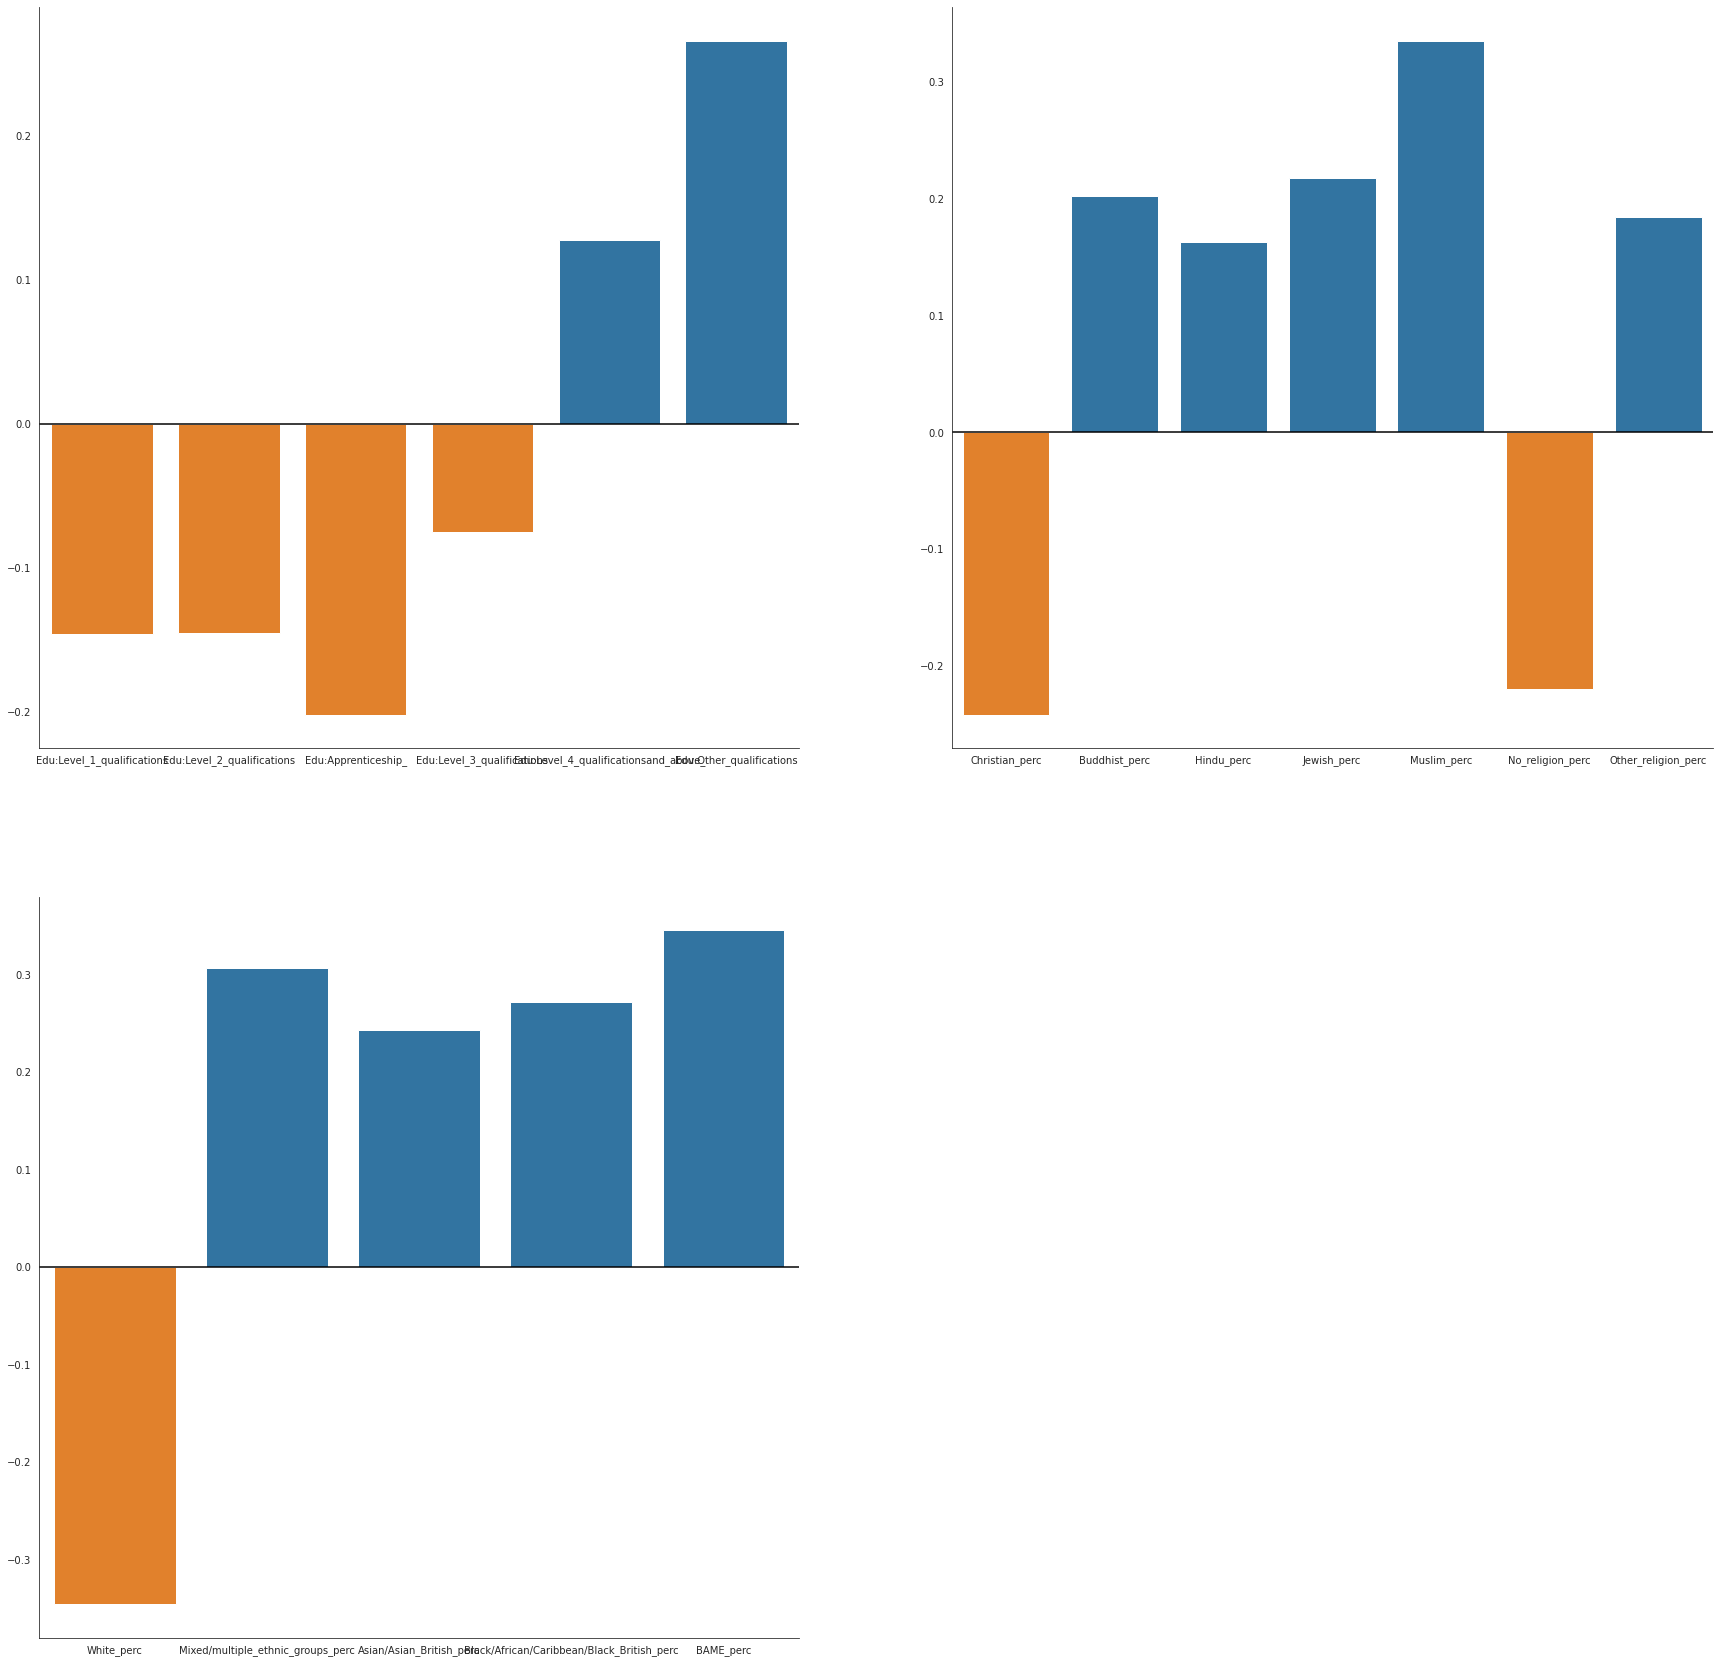

In [76]:
msoa_combined_year_unfiltered = msoa_social.join(msoa_year, how = "inner")
msoa_combined_year_unfiltered.columns = ["_".join(x.split(";")[1:]).replace(" ", "_").replace("(%)_", "perc").replace("(£)", "pound").replace("Highest_level_of_qualification:_", "Edu:").replace("qualifications_", "qualifications") if len(x.split(";")) > 1 else x.replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") for x in msoa_combined_year.columns]

with sns.axes_style("white"): 

    f, axes = plt.subplots(2, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, cat in zip(axes,[education, religions, ethnicities]):
        correl = [(category, stats.spearmanr(a = msoa_combined_year_unfiltered["representativeness_norm"], b = msoa_combined_year_unfiltered[category]).correlation) for category in cat if stats.spearmanr(a = msoa_combined_year_unfiltered["representativeness_norm"], b = msoa_combined_year_unfiltered[category]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        print(colors)
        sns.barplot(x = [x[0] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        #ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

In [77]:
msoa_combined_year["Total_Median_Annual_Household_Income_pound_"].min()

17878

In [83]:
from PyARMViz import datasets
from PyARMViz import PyARMViz

rules = datasets.load_shopping_rules()
adjacency_graph_plotly(rules)

TypeError: Parameters to generic types must be types. Got <module 'PyARMViz.Rule' from 'C:\\Users\\49171\\anaconda3\\lib\\site-packages\\PyARMViz\\Rule.py'>.

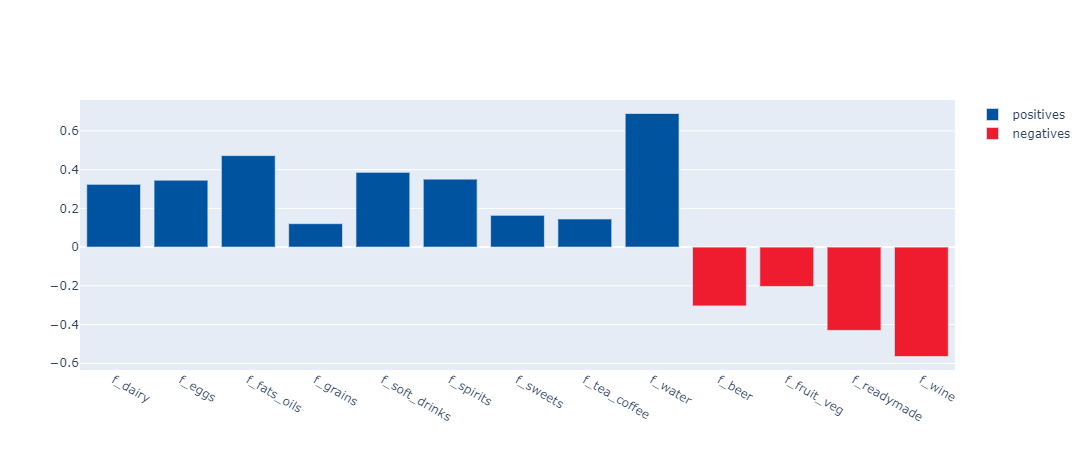

In [114]:
with sns.axes_style("white"): 
    
    correl = [(nutr, stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).correlation) for nutr in products if stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).pvalue < 0.05]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=[c[0] for c in correl if c[1] >= 0], y=[c[1] for c in correl if c[1] >= 0],
                    marker_color= color_tesco_blue,
                    name='positives'))

    fig.add_trace(go.Bar(x=[c[0] for c in correl if c[1] < 0], y=[c[1] for c in correl if c[1] < 0],
                    marker_color= color_tesco_red,
                    name='negatives'))
    fig.show()
    fig.write_html("../fierceeagle.github.io/_includes/Correlation_Product_White.html")

In [111]:
for eth in ["White_perc", "BAME_perc"]:
    
    colors = []

In [85]:
ethnicities

['White_perc',
 'Mixed/multiple_ethnic_groups_perc',
 'Asian/Asian_British_perc',
 'Black/African/Caribbean/Black_British_perc',
 'BAME_perc']

In [94]:
correl

[-0.3039232447843486,
 0.32424875462959524,
 0.3454649675583249,
 0.47265652981948597,
 -0.203332847905256,
 0.12104917942765478,
 -0.43018370805068556,
 0.3861002401676188,
 0.3509532139307974,
 0.16411377031050073,
 0.1452845219226165,
 0.6899123116855048,
 -0.5650054494901922]

In [95]:
[0 if c >= 0 else -c for c in correl]

[0.3039232447843486,
 0,
 0,
 0,
 0.203332847905256,
 0,
 0.43018370805068556,
 0,
 0,
 0,
 0,
 0,
 0.5650054494901922]